<a href="https://colab.research.google.com/github/hdas25/Deep-Learning-Assignments/blob/main/Assignment_2_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔹 1. Import Libraries and Setup

In [ ]:
data_dir = '/content/cat_dog_data'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import zipfile
import random
import requests

from PIL import Image
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


🔹 2. Download and Extract Dataset

In [ ]:
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset_zip = "cats_and_dogs_filtered.zip"

# Download dataset
if not os.path.exists(dataset_zip):
    !wget {dataset_url}

# Extract dataset
if not os.path.exists("cats_and_dogs_filtered"):
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(".")

# Move data to working dir
if not os.path.exists(data_dir):
    shutil.move("cats_and_dogs_filtered", data_dir)
    data_dir = os.path.join(data_dir, "cats_and_dogs_filtered")

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")

--2025-07-02 09:35:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.251, 172.217.164.27, 172.217.0.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   222MB/s    in 0.3s    

2025-07-02 09:35:50 (222 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Download and unzip the dataset
!wget -nc https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip -d /content/


File ‘cats_and_dogs_filtered.zip’ already there; not retrieving.



🔹 3. Define Data Transforms and Loaders

In [ ]:
from torchvision import datasets

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# ✅ Corrected directory path
train_dir = "/content/cats_and_dogs_filtered/train"
val_dir = "/content/cats_and_dogs_filtered/validation"


# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", train_dataset.classes)


Classes: ['cats', 'dogs']


🔹 4. Visualize Random Training Images

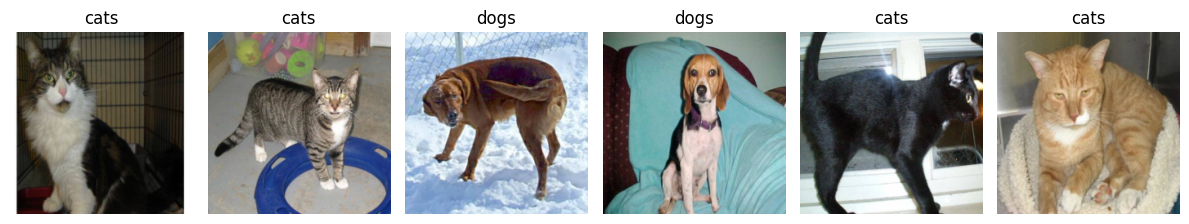

In [ ]:
def show_images(loader, num_images=6):
    images, labels = next(iter(loader))
    fig = plt.figure(figsize=(12, 4))
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Unnormalize
        ax.imshow(img)
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

class_names = train_dataset.classes

show_images(train_loader)


🔹 5. Load Pretrained ResNet-101

In [ ]:
model = models.resnet101(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 63.0MB/s]


🔹 6. Define Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

🔹 7. Training and Evaluation Functions

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_accs, val_accs = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        train_acc = evaluate(model, train_loader)
        val_acc = evaluate(model, val_loader)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader.dataset):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    return train_accs, val_accs


🔹 8. Train the Model

In [ ]:
train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Loss: 0.2488, Train Acc: 98.10%, Val Acc: 98.10%
Epoch [2/5], Loss: 0.0819, Train Acc: 98.30%, Val Acc: 98.20%
Epoch [3/5], Loss: 0.0817, Train Acc: 97.35%, Val Acc: 97.20%
Epoch [4/5], Loss: 0.0935, Train Acc: 98.80%, Val Acc: 98.20%
Epoch [5/5], Loss: 0.0409, Train Acc: 99.35%, Val Acc: 98.00%


🔹 9. Plot Accuracy

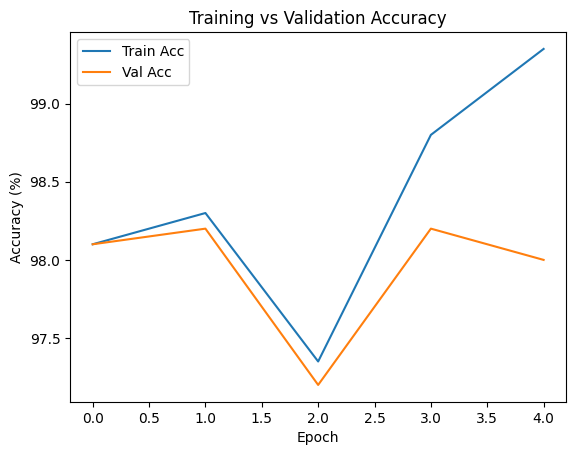

In [ ]:
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

🔹 10. Inference on New Images

In [ ]:
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    image = transform_pipeline(image).unsqueeze(0).to(device)
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    return class_names[predicted.item()]

 Example:

In [ ]:
 predict_image('/content/cat_dog_data/validation/cats/cat.2000.jpg', model)


'cats'